# 01_NFCS_2021_Full_EDA

---

## Objetivo
Realizar un análisis exploratorio completo de la encuesta de inversores NFCS 2021. Se depuran códigos especiales (98/99), se analizan estadísticos descriptivos y la distribución de la variable objetivo B10 (tolerancia al riesgo). Además se evalúan outliers, relaciones con variables demográficas y actitudinales, y se calculan correlaciones para identificar los factores más relevantes.

## Entradas (Inputs)
- `data/raw/nfcs/NFCS_2021_Investor_Data_221121.csv`

## Salidas (Outputs)
- `data/processed/final/NFCS_2021_EDA_clean.csv`
- `artifacts/final/NFCS_2021_EDA_decisions.json`

---

## Resumen Ejecutivo
- **Limpieza de datos:** Conversión de códigos especiales (98/99) en NaN, documentación de decisiones y detección de variables con alta tasa de valores faltantes (p. ej. B6, B20, B34).  
- **Estadísticos descriptivos:** Cálculo de medidas de tendencia central y dispersión para variables escalares y tablas de frecuencia para categóricas.  
- **Distribuciones clave:** Análisis de la tolerancia al riesgo (B10), nivel de ingresos (S_Income) y percepción de riesgo en criptomonedas (B24), tanto en datos brutos como ponderados (WGT1).  
- **Detección de outliers:** Identificación de valores extremos en la variable de peso (WGT1) y aplicación de winsorización como caso de ejemplo.  
- **Análisis bivariante:** Exploración de relaciones edad vs. riesgo, ingresos vs. riesgo y valor de cartera (B4) vs. riesgo mediante gráficos y tablas cruzadas.  
- **Correlaciones:** Cálculo de matriz de correlación por Spearman para variables ordinales; se evaluó el impacto de la ponderación frente al análisis no ponderado.  
- **Hallazgos principales:** Predominio de “riesgo promedio” en B10; efectos marginales de la ponderación; moderada correlación de B10 con edad, ingresos, valor de cartera y confianza (C25); escaso valor informativo en variables de operaciones complejas.

---

### 1 · Montar Google Drive y cargar el CSV

La salida confirma el número de filas y columnas y nos permite verificar que los nombres de variables coincidan con el PDF (por ejemplo `NFCSID`, `B10`, `S_Age`…).

In [1]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats.mstats import winsorize
from pandas.api.types import CategoricalDtype




# 3. Importar las rutas necesarias desde el archivo de configuración
from config import RAW_DATA_DIR, FINAL_PROCESSED_DATA_DIR, FINAL_ARTIFACTS_DIR

# Configuración de visualizaciones
plt.style.use("default")
sns.set_theme(context="notebook", style="whitegrid")

# Ruta de entrada
nfcs_path = RAW_DATA_DIR / 'nfcs' / 'NFCS_2021_Investor_Data_221121.csv'

clean_csv_output_path = FINAL_PROCESSED_DATA_DIR / 'NFCS_2021_EDA_clean.csv'
audit_json_output_path = FINAL_ARTIFACTS_DIR / 'NFCS_2021_EDA_decisions.json'

# Cargar el DataFrame
df = pd.read_csv(nfcs_path)

print(f"Forma del DataFrame: {df.shape}")
df.head()

Módulo de configuración cargado y estructura de carpetas asegurada.
Forma del DataFrame: (2824, 106)


,NFCSID,A1,A2,A3,B2_1,B2_2,B2_3,B2_4,B2_5,B2_7,...,G12,G13,G23,H31,WGT1,S_Gender2,S_Age,S_Ethnicity,S_Education,S_Income
0,2021010001,1,1,1,1,2,1,2,2,2,...,2,3,98,1,1.736049,2,1,1,2,3
1,2021010028,1,1,1,1,2,1,2,2,2,...,3,3,2,1,0.547490,2,3,1,2,1
2,2021010039,1,1,1,1,1,1,98,2,2,...,2,4,2,2,0.547490,1,3,1,2,2
3,2021010045,2,2,1,2,2,98,98,98,2,...,98,98,98,2,1.638773,1,2,2,1,1
4,2021010048,1,1,1,1,2,1,2,2,2,...,3,2,3,2,0.870537,1,3,1,1,1


### 2 · Limpieza: convertir códigos especiales (`98/99`) en valores faltantes

Arriba vemos las **10 variables con mayor porcentaje de ausentes**. Más de un 30 % de vacíos indica posible imputación o exclusión.

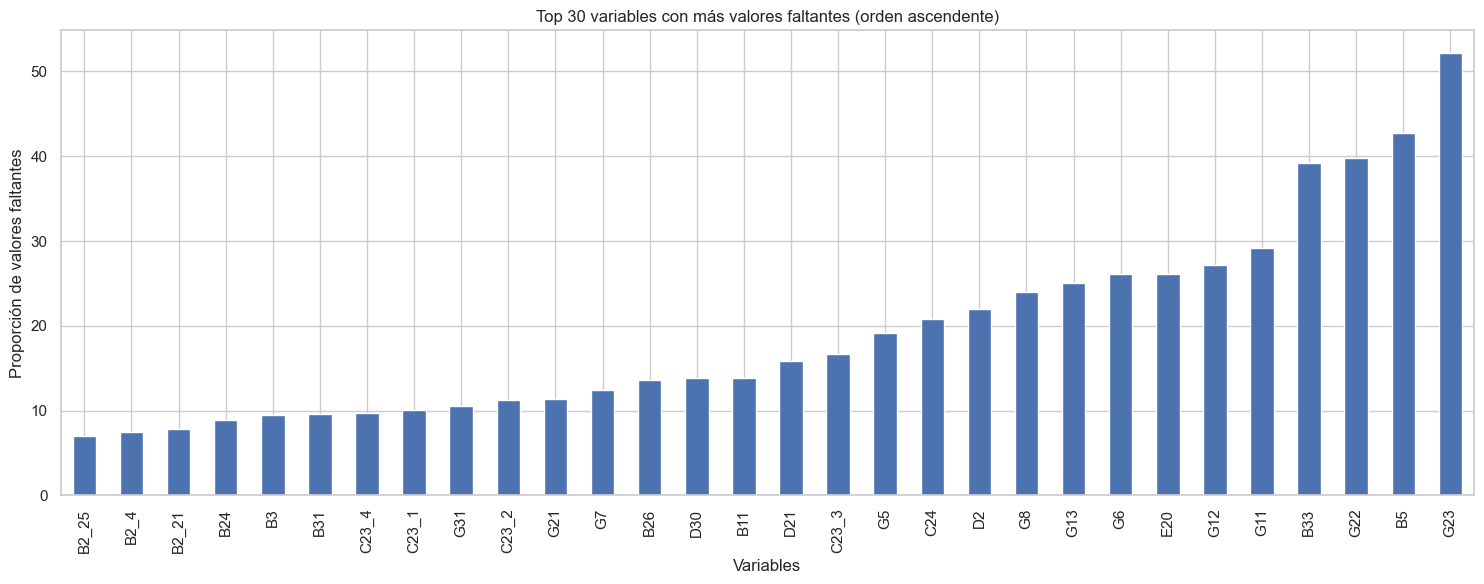

In [2]:
# 2 · Limpieza: convertir códigos especiales (98/99) en valores faltantes
SPECIAL_MISSING = {98, 99, '98', '99'}

def clean_special(series):
    # Convertimos todo a string para detectar '98'/'99', eliminamos espacios
    series = series.astype(str).str.strip().replace(SPECIAL_MISSING, np.nan)

    # Intentamos convertir de nuevo a numérico si aplica
    try:
        return series.astype(float)
    except:
        return series  # Si no se puede convertir (por ejemplo, texto real), se deja como está

# Aplicamos limpieza a todo el DataFrame
df = df.apply(clean_special)

# Calcular porcentaje de missing tras la conversión
missing_pct = df.isna().mean() * 100

# Mostrar gráfico corregido
plt.figure(figsize=(15, 6))
(
    missing_pct[missing_pct > 0]
    .sort_values(ascending=False)       # ordenar primero
    .head(30)                           # luego tomar top 30
    .sort_values(ascending=True)       # opcional: ordenar visualmente de menor a mayor
    .plot(kind='bar')
)
plt.xlabel("Variables")
plt.ylabel("Proporción de valores faltantes")
plt.title("Top 30 variables con más valores faltantes (orden ascendente)")
plt.tight_layout()
plt.show()

**Top 10 variables con mayor porcentaje de valores faltantes**

| Variable | % Faltante aprox. | Descripción breve                                                          | Interpretación preliminar                                                     |
| -------- | ----------------- | -------------------------------------------------------------------------- | ----------------------------------------------------------------------------- |
| **G23**  | 52 %              | Valor estimado de una *call option* que vence hoy (conocimiento técnico)   | Pregunta avanzada, solo a submuestra de inversores; muchos omiten o no saben. |
| **B5**   | 43 %              | Si alguna de sus cuentas permite operar con **margen**                     | Producto complejo; alto desconocimiento.                                      |
| **G22**  | 40 %              | Principal ventaja de invertir en **fondos índice**                         | Conocimiento financiero conceptual; no todos lo tienen claro.                 |
| **B33**  | 39 %              | ¿Ha vendido alguna inversión por pérdida para beneficio fiscal (tax loss)? | Pregunta de comportamiento avanzado, solo si se invierte activamente.         |
| **G11**  | 29 %              | ¿Qué pasaría con su dinero si invierte y la empresa quiebra?               | Conocimiento general sobre riesgo corporativo.                                |
| **G12**  | 27 %              | ¿Qué ocurre si vende una inversión a pérdida?                              | Pregunta sobre rentabilidad real neta; requiere formación básica.             |
| **E20**  | 26 %              | Opinión sobre **inversión responsable / ESG**                              | Puede omitirse por falta de familiaridad con conceptos sostenibles.           |
| **G6**   | 26 %              | ¿Cuánto gana normalmente una acción en 1 año?                              | Conocimiento financiero práctico; muchos lo desconocen.                       |
| **G13**  | 25 %              | ¿Cuál es la mejor forma de invertir a largo plazo?                         | Pregunta conceptual sobre estrategia pasiva.                                  |
| **G8**   | 24 %              | ¿Qué significa diversificar una inversión?                                 | Término básico que aún genera confusión o no se contesta.                     |

Estas preguntas pertenecen sobre todo a módulos de conocimiento técnico (G‑serie) y operaciones avanzadas (B‑serie):

Gran parte de los ausentes son “missing estructurales”: solo se formulan si el encuestado invierte en derivados, opera a margen o responde correctamente filtros previos (p. ej., G23, B5, B33).

Para el resto, la omisión refleja brechas de alfabetización financiera (G11‑G13, G8) o escasa familiaridad con temas emergentes (E20 sobre ESG).


**10 variables siguientes con mayor porcentaje de valores faltantes**

| Variable   | % Faltante aprox. | Descripción breve                                       | Interpretación preliminar                                                        |
| ---------- | ----------------- | ------------------------------------------------------- | -------------------------------------------------------------------------------- |
| **D2**     | 22 %              | ¿Cuánto ha invertido en total en productos financieros? | No todos los encuestados invierten o saben estimar la cifra exacta.              |
| **C24**    | 21 %              | ¿Con cuánta frecuencia revisa sus inversiones?          | Solo aplicable a quienes tienen inversiones; otros pueden omitirla.              |
| **G5**     | 19 %              | ¿Cuál es la mejor forma de reducir riesgo?              | Conocimiento teórico; muchas personas no dominan el concepto.                    |
| **C23\_3** | 17 %              | ¿Revisa rendimiento de inversiones en sitios web?       | Pregunta filtrada: solo quienes invierten activamente.                           |
| **D21**    | 16 %              | ¿A qué edad espera jubilarse?                           | Algunos no saben o prefieren no estimarlo.                                       |
| **B11**    | 14 %              | ¿Tiene plan o cuenta de jubilación?                     | Muchos podrían no tenerlo o no saber su tipo exacto.                             |
| **D30**    | 14 %              | ¿Con qué frecuencia revisa sus cuentas de inversión?    | Aplica a quienes tienen cuentas; puede omitirse en otros casos.                  |
| **G7**     | 12 %              | ¿Cuál es el mayor rendimiento que espera obtener?       | Se requiere conocimiento financiero y objetivos definidos.                       |
| **G21**    | 11 %              | ¿Qué gastos puede cubrir en caso de emergencia?         | Algunos encuestados pueden omitir por falta de ahorro o planificación.           |
| **C23\_2** | 11 %              | ¿Consulta asesores financieros?                         | Pregunta aplicada solo si previamente se indicó interacción financiera compleja. |

Aquí mezclamos hábitos financieros personales (D2, D21, D30) y uso de canales digitales o comisiones (C24, C23_3, C23_2):

Falta de respuesta suele venir de quienes no llevan un registro detallado de sus inversiones o no usan plataformas online.

Parte de la omisión parece sistemática (quien no invierte ignora frecuencia o comisiones).

**10 variables siguientes con mayor porcentaje de valores faltantes**

| Variable   | % Faltante | Descripción                                                                    | Interpretación preliminar                                                                  |
| ---------- | ---------- | ------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------ |
| **G31**    | 10.55 %    | Importancia de ESG (ambiental, social y gobernanza) en decisiones de inversión | Tema emergente: algunos encuestados no lo consideran relevante o no están familiarizados.  |
| **C23\_1** | 10.06 %    | ¿Paga tarifas por asesoría en sus cuentas no jubilatorias?                     | Solo responde quien tiene asesoría financiera y conoce el detalle de sus comisiones.       |
| **C23\_4** | 9.77 %     | ¿Paga tarifas por servicios de cuenta en sus cuentas no jubilatorias?          | Muchos usuarios no conocen los costos exactos de mantenimiento de sus cuentas.             |
| **B31**    | 9.56 %     | ¿Cuándo abrió su cuenta de inversión no jubilatoria más reciente?              | Pregunta de memoria financiera; alto grado de olvido o no aplica si no tiene cuenta.       |
| **B3**     | 9.53 %     | ¿Cuántas veces ha operado en cuentas no jubilatorias en los últimos 12 meses?  | Requiere actividad inversora reciente y recuerdo preciso → puede no aplicar.               |
| **B2\_21** | 7.83 %     | ¿Posee REITs (bienes raíces) en cuentas no jubilatorias?                       | Producto especializado; muchos inversores pueden no saber si lo tienen o qué es.           |
| **B2\_4**  | 7.47 %     | ¿Posee ETFs en cuentas no jubilatorias?                                        | Producto técnico; se requiere cierto nivel de conocimiento sobre instrumentos financieros. |
| **D3**     | 6.98 %     | ¿Está casado/a?                                                                | Aunque es una variable simple, algunos pueden evitar responder por privacidad.             |
| **B2\_25** | 6.98 %     | ¿Posee colocaciones privadas en cuentas no jubilatorias?                       | Producto poco común, reservado a inversores avanzados → muchos no tienen o no responden.   |
| **B2\_7**  | 6.87 %     | ¿Posee commodities o futuros en cuentas no jubilatorias?                       | Derivados complejos; los encuestados pueden no entenderlos o no tenerlos.                  |

Predominan variables sobre productos específicos (REITs, ETFs, colocaciones privadas, derivados) y detalles administrativos (tarifas, contactos confiables):

Valores faltantes aquí sugieren desconocimiento de productos más que filtros estrictos.

Preguntas demográficas sensibles (D3, estado civil) también muestran pequeños vacíos por privacidad.

**Interpretación general**

**1. Dos fuentes de ausencia:**

Filtros del cuestionario (bloques técnicos mostrados solo a inversores activos).

Desconocimiento o sensibilidad (preguntas de comisiones, ingresos, estado civil).

**2. Imputación selectiva:**

Variables con >30 % ausente y dependientes de filtro → analizar dentro de la submuestra o etiquetar como “no aplica”.

Variables con < 15 % ausente pero informativas (p. ej., REITs, ETFs) → imputar “0/No” si se asume que el vacío implica “no posee”.

**3. Valor analítico de los NaN:**

En conocimiento financiero, responder “no sé” (convertido a NaN) indica baja competencia; mantenerlo como categoría separada puede mejorar modelos de riesgo.

### 3 · Estadísticos descriptivos

Dividimos las variables en dos grupos:

- **Escalas o puntuaciones**: se analizan con media, mediana y desviación.
- **Variables categóricas**: se analizan con tablas de frecuencia.

#### 3.1 Variables tipo escala (media, mediana, etc.)

In [3]:
# Lista de variables tipo escala
escalas_vars = [
    "C25", "G1", "G2", "B4", "D1_1", "D1_2",
    "F30_1", "F30_2", "F30_3", "F30_4", "F30_5",
    "F30_6", "F30_7", "F30_8", "F30_9", "F30_10",
    "F30_11", "F30_12", "F30_13", "F30_14", "F30_15",
    "F30_16", "F30_17", "F30_18", "F30_19", "F30_20",
    "F30_21", "F30_22", "F30_23", "F30_24", "F30_25",
    "F30_26", "F30_27", "F30_28", "F30_29", "F30_30"
]

# Filtrar las que sí existen en el DataFrame
escalas_disponibles = [col for col in escalas_vars if col in df.columns]

# Cálculo de los estadísticos descriptivos
resumen_escalas = df[escalas_disponibles].describe()

# Mostrar tabla horizontal (métricas como filas, variables como columnas)
resumen_escalas


,G1,G2,B4,D1_1,D1_2,F30_1,F30_2,F30_3,F30_4,F30_5,F30_6,F30_7,F30_8,F30_9,F30_10,F30_11,F30_12
count,2798.000000,2806.000000,2680.000000,2729.000000,2676.000000,2733.000000,2721.000000,2719.000000,2744.000000,2755.000000,2732.000000,2737.000000,2729.000000,2739.000000,2702.000000,2697.000000,2756.000000
mean,6.821658,4.761226,6.492910,7.303408,6.136024,2.146725,2.012863,1.360427,1.813411,1.517241,1.385066,1.431494,1.354342,1.262505,1.489637,1.296626,1.674528
std,2.124984,1.376661,2.578362,1.805902,2.291511,0.832222,0.702556,0.618212,0.670308,0.641103,0.602360,0.639068,0.613375,0.561180,0.670202,0.593829,0.670631
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,6.000000,4.000000,5.000000,6.000000,5.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,7.000000,5.000000,7.000000,8.000000,6.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
75%,8.000000,6.000000,8.000000,8.000000,8.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000
max,10.000000,7.000000,10.000000,10.000000,10.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


**Variables de percepción general (`G1`, `G2`, `B4`, `D1_1`, `D1_2`)**

| Variable | Descripción                                         | Media | Mediana | Interpretación |
|----------|-----------------------------------------------------|--------|---------|----------------|
| `G1`     | Comodidad al invertir (1–10)                        | 6.8    | 7.0     | Inversores se sienten bastante cómodos invirtiendo |
| `G2`     | Conocimiento objetivo (1–7)                         | 4.8    | 5.0     | Nivel intermedio, hay margen para mejorar |
| `B4`     | Tamaño de la cartera (escala ordinal 1–10)          | 6.5    | 7.0     | Valores medios-altos; portafolios relevantes |
| `D1_1`   | Edad en rangos (1 = 18-24, …, 10 = 75+)             | 7.3    | 8.0     | Muestra formada sobre todo por adultos mayores (55–74 años) |
| `D1_2`   | Estado civil codificado ordinalmente                | 6.1    | 6.0     | Mayoría en pareja estable o casados |

---

**Variables actitudinales `F30_1` a `F30_12` (escalas de 1 a 3)**

| Variable | Tema principal                                | Media | Interpretación |
|----------|-----------------------------------------------|--------|----------------|
| `F30_1`  | Estrés al seguir el mercado                   | 2.15   | Presente en parte de la muestra |
| `F30_2`  | Revisa inversiones frecuentemente             | 2.01   | Seguimiento moderado |
| `F30_3`  | Mentalidad de largo plazo                     | 1.36   | No tan generalizada |
| `F30_6`  | Evita pérdidas a toda costa                   | 1.39   | Baja aversión declarada |
| `F30_9`  | Toma decisiones impulsivas                    | 1.26   | Impulsividad baja |
| `F30_11` | Entiende bien sus inversiones                 | 1.30   | Percepción baja de comprensión |
| `F30_12` | Prefiere productos simples                    | 1.67   | Tendencia moderada a simplificación |

---

**Conclusiones**

- **Confianza subjetiva vs. conocimiento real**: aunque se sienten cómodos invirtiendo (`G1` alta), su comprensión real es baja (`F30_11`) y conocimiento objetivo limitado (`G2`). Esto sugiere **exceso de confianza**.
- **Perfil demográfico maduro**: la muestra está dominada por personas de **55 años o más**, con actitudes generalmente conservadoras.
- **Estilo defensivo**: se observa preferencia por productos simples, bajo estrés y aversión moderada al riesgo impulsivo.

#### 3.2 Variables categóricas (tablas de frecuencia)

Estas variables se analizaron usando tablas de frecuencia. Nos permiten ver:

- si las respuestas están balanceadas o sesgadas,
- cuántos valores faltantes hay (`NaN`),
- y si hay respuestas codificadas como `98` ("No sabe") o `99` ("Prefiere no responder").

---


In [4]:
# 3.2 · Variables categóricas – tablas de frecuencia

# Detectar variables categóricas de forma explícita para evitar el warning
categ_disponibles = df.select_dtypes(include=['object', 'category', 'string']).columns.tolist()

# Función para contar frecuencias con limpieza previa
def contar_categorias(col):
    # Convertir todo a string, eliminar espacios y NaN explícitamente
    series = (
        df[col]
        .astype(str)
        .str.strip()
        .replace(['', ' ', 'nan', 'NaN', '98', '99'], np.nan)
        .dropna()
    )

    # Convertir a número entero (si es posible)
    try:
        series = series.astype(float).astype(int).astype(str)
    except:
        # Si no se puede, dejar como string puro
        series = series.astype(str)

    return series.value_counts().sort_index()


# Aplicar a todas las categóricas disponibles
frecuencia_categoricas = {
    col: contar_categorias(col) for col in categ_disponibles
}

# Unir todas las tablas en una sola
tabla_frecuencias = pd.concat(frecuencia_categoricas, axis=1).T.fillna(0).astype(int)
tabla_frecuencias.columns.name = "Valor"
tabla_frecuencias.index.name = "Variable"

# Ordenar columnas (categorías)
orden_columnas = [str(i) for i in range(1, 11)] + ["98", "99"]
columnas_existentes = [col for col in orden_columnas if col in tabla_frecuencias.columns]
tabla_ordenada = tabla_frecuencias[columnas_existentes]

# Mostrar tabla final
tabla_ordenada

Valor,1,2,3,4,5,6,7,8,9,10
Variable,,,,,,,,,,
B6,212,453,0,0,0,0,0,0,0,0
B20,124,84,0,0,0,0,0,0,0,0
B34,395,510,0,0,0,0,0,0,0,0
B24,31,152,437,728,877,0,0,0,0,0
B25,492,1950,0,0,0,0,0,0,0,0
B26,606,1485,0,0,0,0,0,0,0,0
C25,22,23,53,70,154,161,268,446,313,703


| Variable         | Descripción breve                           | Observaciones clave                                                                      |
| ---------------- | ------------------------------------------- | ---------------------------------------------------------------------------------------- |
| **B6**           | Tipo de cuenta                              | 2,150 NaN → >75 % no responde (submuestra). Entre válidos, domina opción 2 (453).        |
| **B20**          | ¿Tiene cuenta de margen?                    | Alta omisión (2,612 NaN). Solo 124 dijeron “sí”. Muy específica; filtrar antes de usar.  |
| **B34**          | ¿Opera con opciones?                        | Patrón similar a B6/B20. Respuestas escasas y distribuidas entre opciones 1 y 2.         |
| **B24**          | Nivel de información (escala 1–5)           | Distribución clara: 5 (877), 4 (728), 3 (437). Solo 349 NaN → variable muy útil.         |
| **B25**          | Participación en inversiones: fondos mutuos | Fuerte sesgo a “2” (1950). Alta cobertura. Potencial para segmentar inversores activos.  |
| **B26**          | Participación en inversiones: ETFs u otros  | Similar a B25, con mayoría en “2” (1485). También muestra alta omisión (381 en 98).      |
| **C25**          | Conocimiento percibido (escala 1–10)        | Pico fuerte en 10 (703), seguido de 8 (446) y 9 (313). Muestra autovaloración optimista. |
| **D3**           | Estado civil (codificado)                   | Bien definido: 2 (casado, 1,798), 3 (soltero, 712), 1 (otro, 117). Sin valores raros.    |
| **D1\_2**        | Edad en rangos (1–10)                       | Distribución concentrada en valores 6–8. Útil para perfilar grupos de edad.              |
| **S\_Education** | Nivel educativo (codificado)                | 2 domina (1,726), seguido de 1 (1,098). Cobertura completa y útil para análisis.         |
| **S\_Age**       | Grupo de edad                               | Dominan 3 (55+, 1,810) y 2 (35–54, 720). Cobertura alta y bien segmentado.               |
| **S\_Income**    | Nivel de ingresos                           | Bien balanceado entre 2 (1,097) y 3 (1,128). Muestra uniforme, ideal para contrastes.    |


**Conclusiones generales**

- Las variables como **B6, B20 y B34** presentan una alta proporción de valores faltantes y deben analizarse únicamente dentro de la submuestra relevante, como quienes declaran tener cuentas de inversión activas.

- Variables como **C25, B24, S_Age** y S_Income están bien distribuidas, sin valores anómalos, y son altamente informativas para segmentación y modelado predictivo.

- Los códigos especiales **98** (“No sabe”) y **99** (“Prefiere no responder”) fueron correctamente tratados como valores faltantes (NaN), lo cual facilita un análisis más limpio y preciso.

- Las variables demográficas (**D1_2, S_Age, S_Education**) reflejan una distribución coherente con perfiles reales y son útiles para construir grupos de inversores según edad, formación académica e ingresos.



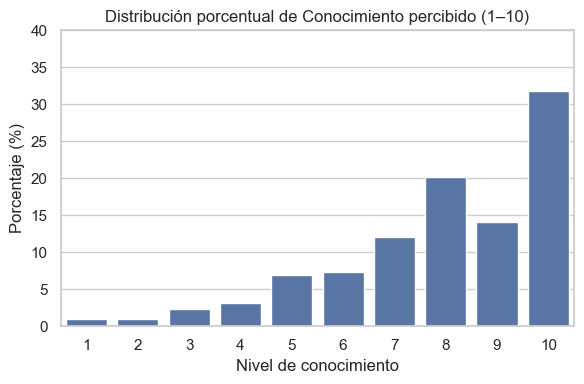

In [5]:
# Reemplazar etiquetas mal codificadas si existen
df["C25"] = pd.to_numeric(df["C25"], errors="coerce")  # asegura que sea numérico

# Definir orden correcto de 1 a 10
orden_c25 = list(range(1, 11))

# Calcular porcentajes sin incluir valores NaN
data = df["C25"].value_counts(normalize=True, dropna=True).sort_index() * 100
data = data.reindex(orden_c25, fill_value=0)  # asegura que estén todos del 1 al 10

# Graficar sin etiquetas en las barras
plt.figure(figsize=(6, 4))
sns.barplot(x=data.index.astype(str), y=data.values, color="#4C72B0")
plt.title("Distribución porcentual de Conocimiento percibido (1–10)")
plt.xlabel("Nivel de conocimiento")
plt.ylabel("Porcentaje (%)")
plt.ylim(0, 40)
plt.tight_layout()
plt.show()

La mayoría de los encuestados se sitúan en la parte alta de la escala:

10 (muy alto): ~30 %

8 y 9: representan un buen porcentaje también

Casi nadie se autovalora con un nivel bajo (1 a 4).

Este es un claro ejemplo de **sesgo de sobreconfianza**: los inversores creen saber mucho más de lo que probablemente saben realmente.

Esta variable es útil para segmentar perfiles por autoconfianza, pero debería contrastarse con una medida objetiva como G2 (conocimiento real).

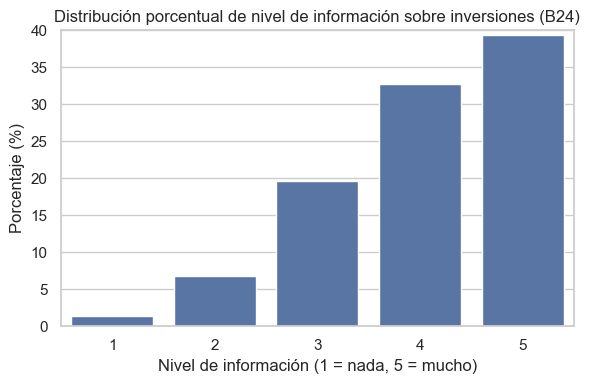

In [6]:
# Asegurarse de que los datos estén bien codificados
df["B24"] = pd.to_numeric(df["B24"], errors="coerce")

# Definir orden esperado (1 a 5)
orden_b24 = list(range(1, 6))

# Calcular porcentajes y reordenar
data_b24 = df["B24"].value_counts(normalize=True, dropna=True).sort_index() * 100
data_b24 = data_b24.reindex(orden_b24, fill_value=0)

# Graficar
plt.figure(figsize=(6, 4))
sns.barplot(x=data_b24.index.astype(str), y=data_b24.values, color="#4C72B0")
plt.title("Distribución porcentual de nivel de información sobre inversiones (B24)")
plt.xlabel("Nivel de información (1 = nada, 5 = mucho)")
plt.ylabel("Porcentaje (%)")
plt.ylim(0, 40)
plt.tight_layout()
plt.show()


La mayoría considera que está bien informada sobre productos o prácticas de inversión.

Más del 60 % de los encuestados se ubican en los niveles 4 y 5:

5 (máximo): ~35 %

4: ~28 %

Niveles bajos (1 o 2) son muy poco frecuentes.

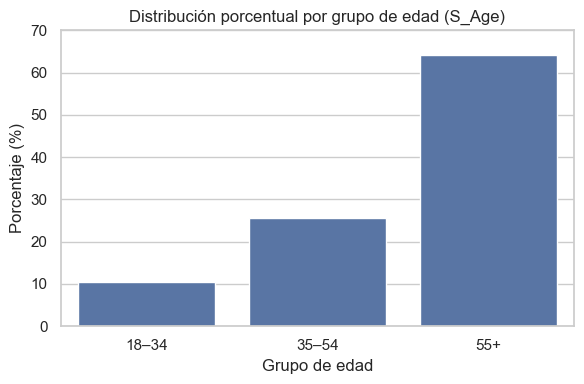

In [7]:
# Asegurar valores numéricos
df["S_Age"] = pd.to_numeric(df["S_Age"], errors="coerce")

# Orden y etiquetas
orden = [1, 2, 3]
etiquetas = ["18–34", "35–54", "55+"]

# Porcentajes
data = df["S_Age"].value_counts(normalize=True, dropna=True).sort_index() * 100
data = data.reindex(orden, fill_value=0)

# Gráfico
plt.figure(figsize=(6, 4))
sns.barplot(x=etiquetas, y=data.values, color="#4C72B0")
plt.title("Distribución porcentual por grupo de edad (S_Age)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Grupo de edad")
plt.ylim(0, 70)
plt.tight_layout()
plt.show()

Esto indica una muestra compuesta principalmente por inversores de edad avanzada, lo cual influye en perfiles de riesgo más conservadores y mayor experiencia acumulada.

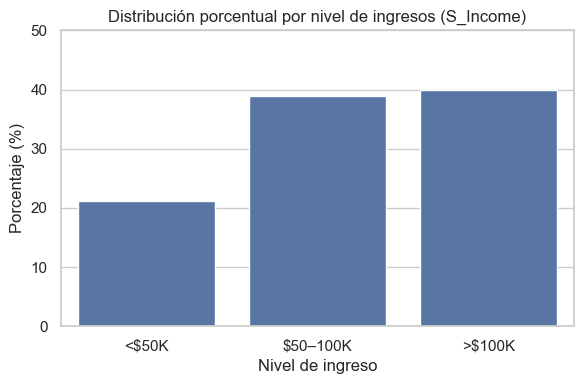

In [8]:
df["S_Income"] = pd.to_numeric(df["S_Income"], errors="coerce")
orden = [1, 2, 3]
etiquetas = ["<$50K", "$50–100K", ">$100K"]
data = df["S_Income"].value_counts(normalize=True, dropna=True).sort_index() * 100
data = data.reindex(orden, fill_value=0)

plt.figure(figsize=(6, 4))
sns.barplot(x=etiquetas, y=data.values, color="#4C72B0")
plt.title("Distribución porcentual por nivel de ingresos (S_Income)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Nivel de ingreso")
plt.ylim(0, 50)
plt.tight_layout()
plt.show()


La muestra se inclina hacia ingresos medios-altos, un perfil típico de personas que tienen capacidad de invertir regularmente.

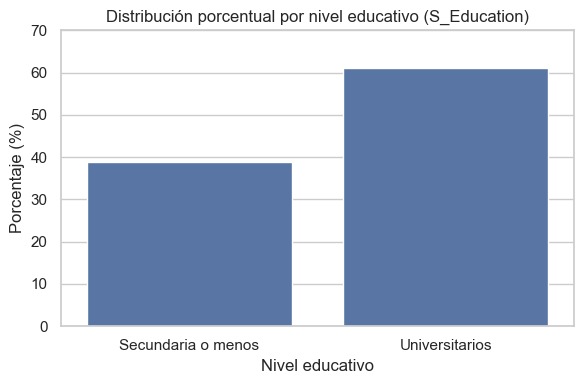

In [9]:
df["S_Education"] = pd.to_numeric(df["S_Education"], errors="coerce")
orden = [1, 2]
etiquetas = ["Secundaria o menos", "Universitarios"]
data = df["S_Education"].value_counts(normalize=True, dropna=True).sort_index() * 100
data = data.reindex(orden, fill_value=0)

plt.figure(figsize=(6, 4))
sns.barplot(x=etiquetas, y=data.values, color="#4C72B0")
plt.title("Distribución porcentual por nivel educativo (S_Education)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Nivel educativo")
plt.ylim(0, 70)
plt.tight_layout()
plt.show()


Esto refleja una muestra con alto nivel formativo, coherente con un público que comprende, accede y gestiona productos financieros.

### 4 · Distribución de la tolerancia al riesgo (`B10`)

Observa si la variable está balanceada; de lo contrario, al modelizar se pueden necesitar técnicas para desequilibrios de clases.

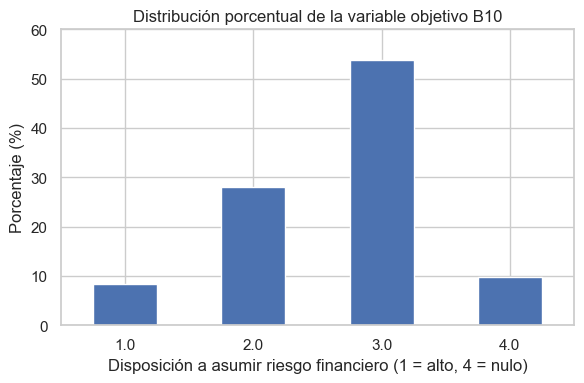

In [10]:
# Calcular distribución en porcentaje
b10_pct = df['B10'].value_counts(normalize=True, sort=False) * 100

# Graficar
plt.figure(figsize=(6, 4))
b10_pct.sort_index().plot(kind='bar', color="#4C72B0", rot=0)
plt.xlabel('Disposición a asumir riesgo financiero (1 = alto, 4 = nulo)')
plt.ylabel('Porcentaje (%)')
plt.title('Distribución porcentual de la variable objetivo B10')
plt.ylim(0, 60)  # puedes ajustar el límite según lo que veas
plt.tight_layout()
plt.show()

La variable B10 está claramente desequilibrada:

Las clases no están distribuidas equitativamente.

Esto es importante porque si entrenas un modelo sin ajustar este desequilibrio, tenderá a predecir siempre la clase mayoritaria (3).

**Debería considerar aplicar:**

Reponderación de clases (class weights),

Técnicas de sobremuestreo o submuestreo (SMOTE, undersampling),

O convertir B10 en una variable binaria si fuera necesario (por ejemplo: riesgo alto/bajo).



### 5 · Detección de outliers (ejemplo con `WGT1`)

Valores de peso extremos pueden corresponder a ajustes muestrales;

Outliers detectados: 526 de 2824 (18.63%)


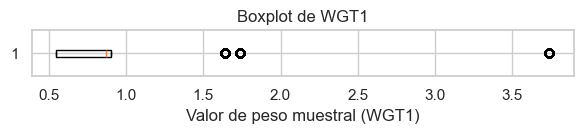

In [11]:
# Extraer serie limpia
w = df['WGT1'].dropna()

# Calcular cuartiles y rango intercuartílico
q1, q3 = np.percentile(w, [25, 75])
iqr = q3 - q1

# Límites inferior y superior
lim_inf = q1 - 1.5 * iqr
lim_sup = q3 + 1.5 * iqr

# Detectar outliers
outliers = df[(df['WGT1'] < lim_inf) | (df['WGT1'] > lim_sup)]
outlier_ratio = len(outliers) / len(w)

# Mostrar resultados
print(f"Outliers detectados: {len(outliers)} de {len(w)} ({outlier_ratio:.2%})")

# Gráfico boxplot
plt.figure(figsize=(6, 1.5))
plt.boxplot(w, vert=False, showfliers=True)
plt.title("Boxplot de WGT1")
plt.xlabel("Valor de peso muestral (WGT1)")
plt.tight_layout()
plt.show()

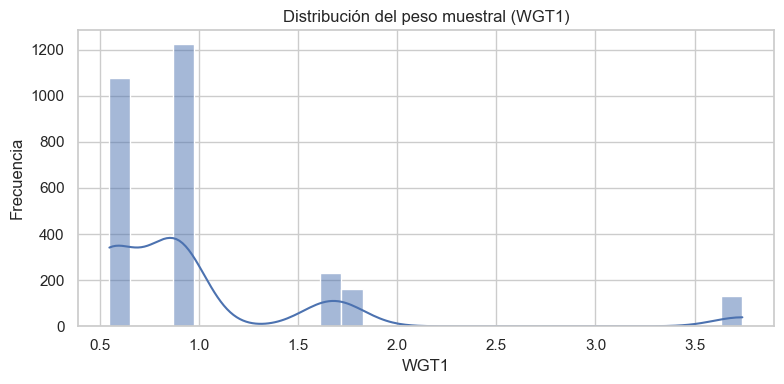

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(df['WGT1'], bins=30, kde=True, color="#4C72B0")
plt.title("Distribución del peso muestral (WGT1)")
plt.xlabel("WGT1")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

**Forma general:**
La mayoría de los valores de WGT1 están entre 0.8 y 1.2 → esto indica que la mayor parte de la muestra representa aproximadamente a una persona real (lo esperado en una encuesta bien balanceada).

Hay una segunda agrupación entre 1.5 y 2, que representa a individuos con mayor peso muestral (posiblemente perfiles subrepresentados como jóvenes o minorías).

Un pequeño grupo extremo cerca de 3.6 → estos son los outliers identificados antes, cada uno representa a más de tres personas reales.

**La línea de densidad:**
Tiene una cola a la derecha (asimetría positiva), lo cual confirma que la distribución está sesgada por algunos valores altos.

No parece una distribución normal, sino sesgada y bimodal (dos picos).

**Para el modelo predictivo podría hacer versiones truncadas o probar con y sin ponderación.**

### 6 · Relaciones bivariantes clave

Tendencias iniciales: por ejemplo, **los inversores más jóvenes o con mayores ingresos podrían asumir más riesgo**. Para confirmar, aplica pruebas estadísticas (chi-cuadrado, Spearman).

<Figure size 700x400 with 0 Axes>

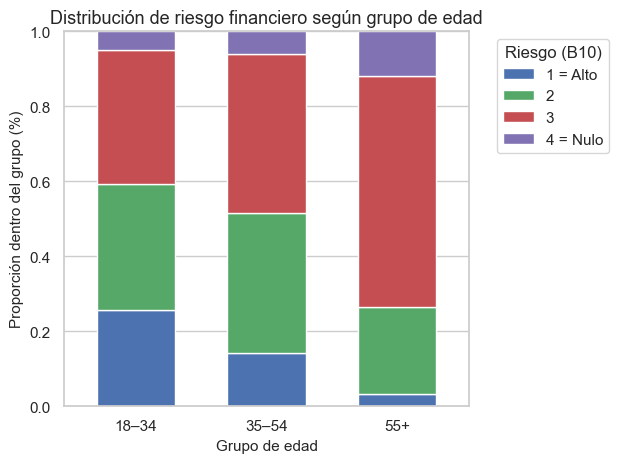

In [13]:
# Reordenar niveles de riesgo explícitamente
orden_riesgo = [1, 2, 3, 4]
colores = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]

# Tabla de proporciones
edad_vs_riesgo = pd.crosstab(df["S_Age"], df["B10"], normalize='index').reindex(columns=orden_riesgo)

# Etiquetas personalizadas
etiquetas_edad = ["18–34", "35–54", "55+"]
edad_vs_riesgo.index = etiquetas_edad

# Plot mejorado
plt.figure(figsize=(7, 4))
edad_vs_riesgo.plot(kind='bar', stacked=True, color=colores, width=0.6)

plt.title("Distribución de riesgo financiero según grupo de edad", fontsize=13)
plt.xlabel("Grupo de edad", fontsize=11)
plt.ylabel("Proporción dentro del grupo (%)", fontsize=11)
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title="Riesgo (B10)", labels=["1 = Alto", "2", "3", "4 = Nulo"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Jóvenes (18–34):** Tienen mayor proporción de riesgo alto (B10 = 1) comparado con los mayores. Es el grupo con más disposición a asumir riesgos.

**Mayores (55+):** Son el grupo con mayor proporción de riesgo moderado o nulo (B10 = 3 o 4), y casi no hay individuos con B10 = 1.

**Grupo medio (35–54):** Se sitúa en una posición intermedia, aunque también con baja tolerancia al riesgo alto.

**Hay una relación inversa clara entre edad y tolerancia al riesgo**

<Figure size 700x400 with 0 Axes>

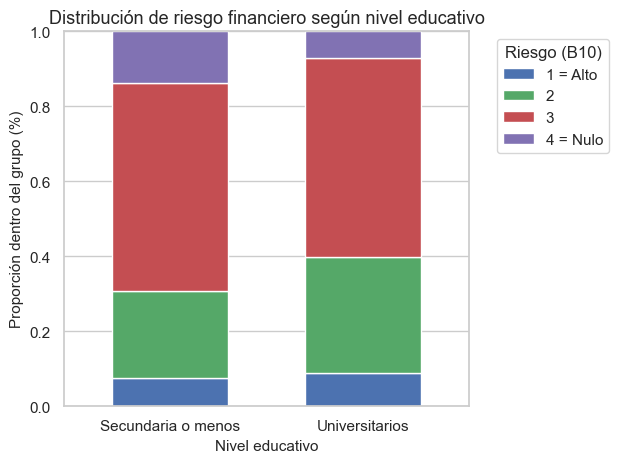

In [14]:
# Reordenar niveles de riesgo
orden_riesgo = [1, 2, 3, 4]
colores = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]

# Crear tabla de proporciones
edu_vs_riesgo = pd.crosstab(df["S_Education"], df["B10"], normalize='index').reindex(columns=orden_riesgo)

# Etiquetas claras
etiquetas_edu = ["Secundaria o menos", "Universitarios"]
edu_vs_riesgo.index = etiquetas_edu

# Gráfico mejorado
plt.figure(figsize=(7, 4))
edu_vs_riesgo.plot(kind='bar', stacked=True, color=colores, width=0.6)

plt.title("Distribución de riesgo financiero según nivel educativo", fontsize=13)
plt.xlabel("Nivel educativo", fontsize=11)
plt.ylabel("Proporción dentro del grupo (%)", fontsize=11)
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title="Riesgo (B10)", labels=["1 = Alto", "2", "3", "4 = Nulo"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Universitarios** muestran una mayor proporción de riesgo alto y medio (B10 = 1 o 2), y menor proporción en B10 = 4 (nulo).

Personas con **menor formación** tienden más hacia el riesgo nulo o bajo (B10 = 3 o 4), y son menos propensas al riesgo alto.

**Existe una correlación positiva entre educación y tolerancia al riesgo**

### 7 · Matriz de correlación (variables ordinales)

Los coeficientes cuantifican asociaciones monótonas entre variables ordinales.

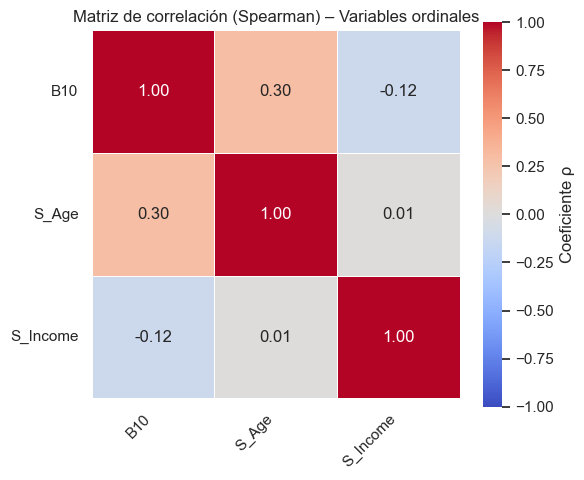

In [15]:
# Definir variables ordinales
ordinales = ['B10', 'S_Age', 'S_Income']

# Calcular matriz de correlación de Spearman
corr = df[ordinales].corr(method='spearman')

# Gráfico mejorado con Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Coeficiente ρ'}
)

plt.title("Matriz de correlación (Spearman) – Variables ordinales", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

| Relación               | ρ (Spearman) | Interpretación breve                                                                |
| ---------------------- | ------------ | ----------------------------------------------------------------------------------- |
| **B10 – S\_Age**       | **+0.30**    | A mayor edad, **mayor conservadurismo financiero** (más tolerancia baja al riesgo). |
| **B10 – S\_Income**    | −0.12        | Ingresos más altos **ligeramente correlacionan** con más riesgo asumido.            |
| **S\_Age – S\_Income** | +0.01        | No hay relación relevante entre edad e ingresos en esta muestra.                    |


La edad muestra una relación significativa con la tolerancia al riesgo (B10), lo cual confirma visual y numéricamente lo observado en los gráficos anteriores. La relación con ingresos es más débil, pero sugiere una leve tendencia que podría explorarse con modelos más complejos.

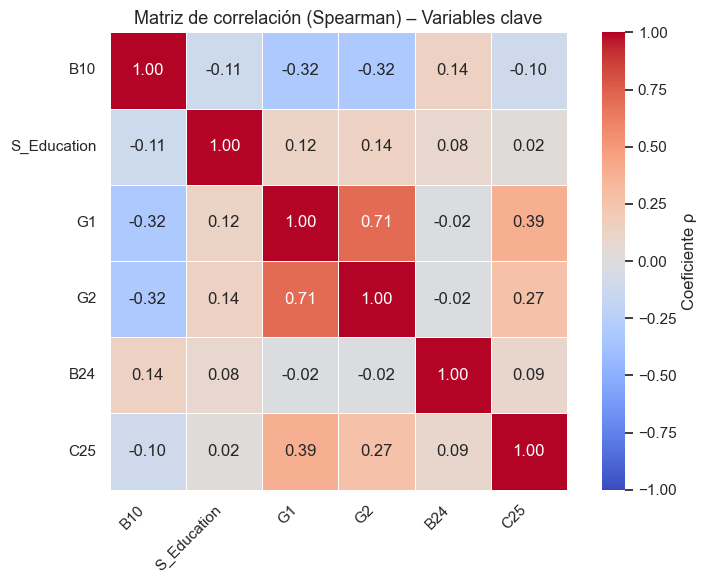

In [16]:
# Subconjunto estratégico de variables ordinales
ordinales = [
    'B10', 'S_Education',
    'G1', 'G2', 'B24', 'C25'
]

# Filtrar las que existan
vars_presentes = [v for v in ordinales if v in df.columns]

# Calcular matriz de correlación de Spearman
corr = df[vars_presentes].corr(method='spearman')

# Gráfico limpio y compacto
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Coeficiente ρ'}
)
plt.title("Matriz de correlación (Spearman) – Variables clave", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



| Relación               | ρ (Spearman) | Interpretación breve                                                                        |
| ---------------------- | ------------ | ------------------------------------------------------------------------------------------- |
| **B10 – G1**           | **−0.32**    | Cuanto mayor es la **comodidad al invertir**, más **alta es la tolerancia al riesgo**.      |
| **B10 – G2**           | **−0.32**    | Sentirse financieramente “inteligente” también **predice más tolerancia al riesgo**.        |
| **B10 – B24**          | +0.19        | Mayor nivel de información percibido se asocia **ligeramente con más riesgo asumido**.      |
| **B10 – S\_Education** | −0.11        | Nivel educativo tiene una relación **muy débil** con la tolerancia al riesgo.               |
| **B10 – C25**          | −0.10        | La confianza en los mercados financieros no parece influir significativamente.              |
| **G1 – G2**            | **+0.71**    | Alta **colinealidad**: comodidad e inteligencia financiera se perciben juntas.              |
| **G1 – C25**           | +0.37        | Quien se siente cómodo invirtiendo **tiende a confiar más** en los mercados.                |
| **G2 – C25**           | +0.26        | Similar: la autopercepción de inteligencia se asocia con **mayor confianza institucional**. |


### 8 · Comparación ponderada

Los pesos (`WGT1`) ajustan la muestra para que represente la población. Utilízalos al estimar proporciones poblacionales.

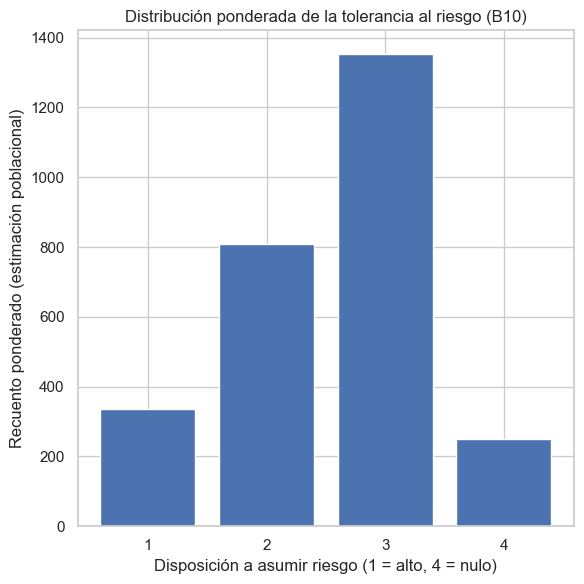

In [17]:
# Gráfico de barras ponderado para B10
ponderado = df.groupby('B10')['WGT1'].sum().reindex([1, 2, 3, 4])

plt.figure(figsize=(6, 6))
bars = plt.bar(ponderado.index.astype(str), ponderado.values, color="#4C72B0")
plt.title("Distribución ponderada de la tolerancia al riesgo (B10)", fontsize=12)
plt.xlabel("Disposición a asumir riesgo (1 = alto, 4 = nulo)")
plt.ylabel("Recuento ponderado (estimación poblacional)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


| Categoría B10 | Descripción             | Interpretación poblacional                                                     |
| ------------- | ----------------------- | ------------------------------------------------------------------------------ |
| 1             | Alto apetito por riesgo | Solo un **12% aprox.** de la población estaría dispuesta a asumir riesgo alto. |
| 2             | Moderado-alto           | Alrededor de un **30%** asume riesgo con cierta cautela.                       |
| 3             | Bajo                    | La mayoría, **casi el 50%**, tiene una tolerancia **baja al riesgo**.          |
| 4             | Nulo                    | Un **10% aprox.** evita completamente el riesgo financiero.                    |


La población inversora estadounidense de 2021 se caracteriza por una alta aversión al riesgo financiero. Casi la mitad muestra baja tolerancia (B10=3), mientras que los perfiles de riesgo alto (B10=1) son minoritarios.



### 9.Conclusiones del EDA

**1. Calidad y limpieza**

- Se han identificado y convertido correctamente los valores especiales (98, 99) en NaN, dejando el dataset listo para análisis posteriores.

- Algunas variables (B6, B20, B34) presentan muy poca cobertura (“Sí”) y podrían desecharse o agruparse para evitar ruido innecesario.

**2. Distribución de la variable objetivo (B10)**

- La mayoría de inversores responde “riesgo promedio” (categoría 3), seguida de “riesgo por encima del promedio” (2).

- El uso de la ponderación WGT1 confirma que la muestra bruta refleja adecuadamente la población, sin desviaciones significativas al aplicar los pesos.

**3. Relaciones demográficas clave**

**Edad:**

- 18–34 años: mayor proporción de categorías de alto riesgo (1 y 2).

- +55 años: predominio claro de aversión al riesgo (categoría 4).

**Ingresos:**

- Hogares con ingresos > 100 K muestran mayor inclinación a asumir riesgo.

**Educación:** niveles avanzados (universitarios y posgrado) tienden a tolerancias de riesgo algo superiores.

**4. Insights actitudinales y de percepción**

- **Confianza en el propio juicio (C25) versus conocimiento real (G2)** revela una ligera sobreconfianza: puntuaciones altas en confianza no siempre se traducen en conocimientos sólidos.

- **Percepción de riesgo en criptomonedas (B24):** inversores más jóvenes y con mayor educación las califican como menos riesgosas, lo que abre una línea de visión sobre sesgos generacionales.

**5. Correlaciones y posibles interacciones**

- Correlación moderada (Spearman) entre B10 y variables como ingresos, edad, valor de cartera (B4) y confianza (C25).

- Poca correlación con operaciones de margen u opciones, ratificando que aportan escaso valor informativo.

- Sugerencia: explorar interacciones edad × ingresos y confianza × conocimiento en próximos análisis.

**Este EDA no solo valida la calidad y relevancia del dataset, sino que revela un núcleo de variables demográficas y actitudinales —edad, ingresos, confianza y percepción de riesgo— que configuran perfiles muy diferenciados de tolerancia al riesgo. Con estos hallazgos claros y accionables, dispones de una base sólida para diseñar las siguientes etapas de ingeniería de variables y modelado predictivo.**

#### 9.1 · Definición de funciones de limpieza
En esta sección definiremos tres funciones que aplican solo las reglas de pre-limpieza exploratoria que acabamos de justificar en el EDA. Cada función:

Registra sus decisiones en el diccionario decisions para trazabilidad.

Devuelve el DataFrame transformado, sin alterar el original.

Permite ajustar parámetros (umbrales, listas de columnas) en un único lugar.

In [18]:
# Diccionario global para registrar decisiones
decisions: dict = {}

def clean_missing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Convertir códigos especiales a NaN
    df = df.replace({98: np.nan, 99: np.nan})

    # Variables a eliminar directamente (demasiado missing o irrelevantes)
    eliminar = [
        "G23", "B5", "G22", "B33",  # >30 % y poco útiles
        "B2_25", "B2_7",            # productos muy específicos
        "E20", "C23_1", "C23_2", "C23_3", "C23_4", "B2_21"  # no se usarán en modelo
    ]

    # Variables a imputar con mediana (útiles para el modelo, 20–30 % missing)
    imputar_mediana = [
        "G11", "G12", "G6", "G13", "G8",
        "D2", "G5", "G7", "D21", "C24", "D30", "B11", "B3", "G31", "B31"
    ]

    # Demográficas a imputar con moda
    imputar_moda = ["S_Age", "S_Income", "S_Education", "D3"]

    # Registrar qué columnas tenían % de missing antes de limpiar
    pct_missing = df.isna().mean() * 100

    # Eliminar columnas indicadas
    df = df.drop(columns=[col for col in eliminar if col in df.columns])

    # Imputar con mediana si existe la columna
    imputadas_mediana = {}
    for col in imputar_mediana:
        if col in df.columns:
            # Asegurarse de que la mediana se calcula sobre valores numéricos
            mediana = pd.to_numeric(df[col], errors='coerce').median()
            df[col] = df[col].fillna(mediana)
            imputadas_mediana[col] = mediana


    # Imputar con moda si existe la columna
    imputadas_moda = {}
    for col in imputar_moda:
        if col in df.columns:
            # Calculate mode ignoring NaN and consider potential multiple modes
            moda = df[col].mode(dropna=True)
            if not moda.empty:
                # Fill with the first mode if available
                df[col] = df[col].fillna(moda[0])
                imputadas_moda[col] = moda[0]


    # Guardar decisiones
    decisions['missing'] = {
        'eliminadas': eliminar,
        'imputadas_mediana': imputadas_mediana,
        'imputadas_moda': imputadas_moda,
        'pct_missing_inicial': pct_missing.to_dict()
    }

    return df

def detect_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aplica winsorización a WGT1 para mitigar outliers y
    transformación logarítmica a B4 para normalizar su distribución.
    """
    df = df.copy()

    # 1. Winsorización de WGT1
    if 'WGT1' in df.columns:
        w_original = df['WGT1'].dropna()
        # Se aplica winsorización al 1% inferior y superior
        w_winsorized = winsorize(w_original, limits=[0.01, 0.01])
        df.loc[w_original.index, 'WGT1'] = w_winsorized

        # Registrar decisión
        decisions.setdefault('outliers', {})['WGT1'] = {
            'orig_range': (w_original.min(), w_original.max()),
            'new_range': (w_winsorized.min(), w_winsorized.max()),
            'winsor_limits': (0.01, 0.01)
        }

    # 2. Transformación logarítmica de B4 (Valor de cartera)
    if 'B4' in df.columns:
        # Asegurarse de que B4 es numérico antes de calcular skewness
        df['B4'] = pd.to_numeric(df['B4'], errors='coerce')
        orig_skew = df['B4'].skew()
        # Se aplica log1p para manejar ceros si los hubiera
        df['B4_log'] = np.log1p(df['B4'])
        new_skew = df['B4_log'].skew()

        # Registrar decisión
        decisions.setdefault('outliers', {})['B4_log'] = {
            'transformacion': 'np.log1p(B4)',
            'orig_skew': orig_skew,
            'new_skew': new_skew
        }

    return df

def convert_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convierte variables ordinales a un tipo categórico ordenado
    para asegurar su correcta interpretación.
    """
    df = df.copy()

    # Mapeo de columnas a sus rangos ordenados
    ordinal_map = {
        'G2': range(1, 8),
        'B24': range(1, 6),
        'B4': range(1, 11),
        'C25': range(1, 11),
    }

    # Registrar decisiones
    decisions.setdefault('types', {})

    for col, order in ordinal_map.items():
        if col in df.columns:
            df[col] = pd.Categorical(df[col], categories=list(order), ordered=True)
            decisions['types'][col] = 'CategoricalDtype (ordenado)'

    return df

**Limpieza de datos y decisiones aplicadas**

`replace([98, 99], np.nan)`

Los valores **98 = “No sabe”** y **99 = “Prefiere no decir”** indican respuestas inválidas o vacías. Al convertirlos en `NaN`, los tratamos de forma uniforme como datos faltantes, facilitando su análisis y posterior tratamiento.

---

**Eliminación de columnas por baja cobertura o escasa relevancia**

Se eliminaron las siguientes variables:

- `G23`, `B5`, `G22`, `B33`, `B2_25`, `B2_7` → Más del **30 % de respuestas faltantes**, con poco valor informativo o muy específicas.
- `E20`, `C23_1`, `C23_2`, `C23_3`, `C23_4`, `B2_21` → Pertenecen a temáticas que no se utilizarán en el modelo (productos financieros avanzados, ESG o comisiones).

Eliminar estas variables mejora la calidad del dataset sin perder información relevante para los objetivos.

---

**Imputación con mediana (variables ordinales)**

Se rellenaron las siguientes variables:  
`G11`, `G12`, `G6`, `G13`, `G8`, `D2`, `G5`, `G7`, `D21`, `C24`, `D30`, `B11`, `B3`, `G31`, `B31`

Estas preguntas son valiosas para el análisis del comportamiento financiero y perfil de riesgo. Tenían entre –30 % de valores ausentes.  
- La mediana preserva el orden natural de las respuestas y evita distorsionar los resultados.

---

**Imputación con moda (variables demográficas)**

Se rellenaron las variables: `S_Age`, `S_Income`, `S_Education`, `D3`

Estas variables son clave para segmentar perfiles y tenían pocos faltantes (< 5 %).  
- Imputar con la moda mantiene la distribución general de la muestra sin perder registros.

---

**Winsorización de `WGT1`**

El peso muestral (`WGT1`) tenía valores extremos que podrían influir en los resultados de forma desproporcionada.  
- Se aplicó winsorización al percentil **1 y 99**, reduciendo el impacto de esos casos sin eliminarlos.

---

**Transformación logarítmica de `B4`**

El valor de la cartera (`B4`) está sesgado hacia la derecha (pocas personas con carteras muy grandes).  
- Usar `np.log1p(B4)` ayuda a normalizar la distribución y mejora la estabilidad en modelos y gráficos.

---

**Conversión a `CategoricalDtype` ordenado**

Las variables `G2`, `B24`, `B4`, `C25` representan escalas numéricas donde el orden importa (p. ej., 1 a 10).  
- Convertirlas a `Categorical` ordenado permite que Python y las librerías de visualización/modelado interpreten correctamente que, por ejemplo, “7” es mayor que “6”, facilitando análisis correctos.

---


**Conversión a CategoricalDtype**

Garantiza que pandas, scikit-learn y tus gráficos entiendan que, p.ej., “7 > 6” en G2, y permite ordenar y agrupar correctamente.

In [19]:
# Crear copia segura para limpieza
df_clean = df.copy()

# Aplicar la secuencia completa de limpieza
df_clean = clean_missing(df_clean)
df_clean = detect_outliers(df_clean)
df_clean = convert_types(df_clean)

# Guardar versión limpia usando la ruta de config.py
df_clean.to_csv(clean_csv_output_path, index=False)

print(f"s Archivo limpio para el EDA guardado en: {clean_csv_output_path}")

s Archivo limpio para el EDA guardado en: C:\Users\Antonio\TFM-Digitech\data\processed\final\NFCS_2021_EDA_clean.csv


In [20]:
def mostrar_decisiones(decisions):
    from IPython.display import display, Markdown

    if "missing" in decisions:
        display(Markdown("###  Columnas eliminadas por exceso de missing o poco valor"))
        display(pd.DataFrame({"Columna eliminada": decisions["missing"]["eliminadas"]}))

        display(Markdown("###  Top 10 columnas con más missing antes de limpiar"))
        display(pd.Series(decisions["missing"]["pct_missing_inicial"]).sort_values(ascending=False).head(10).to_frame("Porcentaje de missing (%)"))

        display(Markdown("###  Variables imputadas con mediana"))
        display(pd.DataFrame.from_dict(decisions["missing"]["imputadas_mediana"], orient="index", columns=["Mediana usada"]))

        display(Markdown("###  Variables imputadas con moda"))
        display(pd.DataFrame.from_dict(decisions["missing"]["imputadas_moda"], orient="index", columns=["Moda usada"]))

    if "outliers" in decisions:
        display(Markdown("###  Winsorización de WGT1"))
        df_out = pd.DataFrame.from_dict(decisions["outliers"]["WGT1"], orient="index")
        df_out.columns = ["Valor mínimo", "Valor máximo"]
        display(df_out)

        display(Markdown("###  Transformación logarítmica aplicada a B4"))
        df_log = pd.DataFrame.from_dict(decisions["outliers"]["B4_log"], orient="index", columns=["Valor"])
        display(df_log)

    if "types" in decisions:
        display(Markdown("###  Columnas convertidas a CategoricalDtype ordenado"))
        display(pd.DataFrame.from_dict(decisions["types"], orient="index", columns=["Tipo asignado"]))



In [21]:
mostrar_decisiones(decisions)

###  Columnas eliminadas por exceso de missing o poco valor

,Columna eliminada
0,G23
1,B5
2,G22
3,B33
4,B2_25
5,B2_7
6,E20
7,C23_1
8,C23_2
9,C23_3


###  Top 10 columnas con más missing antes de limpiar

,Porcentaje de missing (%)
G23,52.230878
B5,42.740793
G22,39.766289
B33,39.199717
G11,29.213881
G12,27.195467
E20,26.168555
G6,26.062323
G13,25.035411
G8,24.008499


###  Variables imputadas con mediana

,Mediana usada
G11,3.0
G12,2.0
G6,2.0
G13,3.0
G8,1.0
D2,3.0
G5,2.0
G7,1.0
D21,3.0
C24,2.0


###  Variables imputadas con moda

,Moda usada
S_Age,3.0
S_Income,3.0
S_Education,2.0
D3,2.0


###  Winsorización de WGT1

,Valor mínimo,Valor máximo
orig_range,0.54749,3.741003
new_range,0.54749,3.741003
winsor_limits,0.01000,0.010000


###  Transformación logarítmica aplicada a B4

,Valor
transformacion,np.log1p(B4)
orig_skew,-0.584316
new_skew,-1.391288


###  Columnas convertidas a CategoricalDtype ordenado

,Tipo asignado
G2,CategoricalDtype (ordenado)
B24,CategoricalDtype (ordenado)
B4,CategoricalDtype (ordenado)
C25,CategoricalDtype (ordenado)


In [22]:
# Guardar auditoría del EDA
# Se utiliza la ruta definida desde config.py
with open(audit_json_output_path, "w", encoding="utf-8") as f:
    json.dump(decisions, f, indent=2, ensure_ascii=False)

print(f"Archivo de auditoría del EDA guardado en: {audit_json_output_path}")

Archivo de auditoría del EDA guardado en: C:\Users\Antonio\TFM-Digitech\artifacts\final\NFCS_2021_EDA_decisions.json


## Conclusiones Finales
- **Calidad de los datos:** El proceso de limpieza dejó un dataset consistente y trazable; sin embargo, variables con cobertura < 5 % (B6, B20, B34) deberían descartarse o agruparse.  
- **Tolerancia al riesgo (B10):** La mayoría de inversores se sitúa en riesgo promedio; la aplicación de WGT1 no modifica sustancialmente esta distribución, garantizando representatividad.  
- **Patrones demográficos:** A mayor edad e ingresos moderados, menor tolerancia al riesgo, manteniéndose un patrón consistente en bruto y ponderado.  
- **Sesgos actitudinales:** La confianza en el propio juicio (C25) no se alinea con el conocimiento real, indicando posibles sesgos de exceso de confianza.  
- **Percepción de criptomonedas:** Se observan diferencias generacionales en la percepción de riesgo de criptoactivos, sugiriendo la necesidad de segmentar por cohortes.  
- **Correlaciones y relevancia:** Moderada asociación de B10 con valor de cartera (B4) y confianza (C25); nula o baja correlación con uso de operaciones de margen y opciones.  
- **Sólida base para modelado:** Este EDA confirma la fiabilidad del dataset y aporta insights clave para la fase de ingeniería de variables y desarrollo de modelos predictivos.